### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import torch.optim as optim
import cv2
import math
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Autoencoder training process

Data loading

In [8]:
class AutoencoderDataset(Dataset):
    def __init__(self, root_dir, image_type1="img1.png", image_type2="corner1.png", transform=None):
        """
        root_dir: path to dataset (e.g., "synthetic_dataset_complex")
        image_type1: input image name (e.g., "img1.png")
        image_type2: target image name (e.g., "ellipse1.png")
        transform: optional transform function (should operate on tensors or arrays)
        """
        self.root_dir = root_dir
        self.sample_dirs = sorted([
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.image_type1 = image_type1
        self.image_type2 = image_type2
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_path = self.sample_dirs[idx]

        input_path = os.path.join(sample_path, self.image_type1)
        target_path = os.path.join(sample_path, self.image_type2)

        # Load input and target images, normalize
        input_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        target_img = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

        input_img = np.expand_dims(input_img, axis=0)   # Shape: (1, H, W)
        target_img = np.expand_dims(target_img, axis=0) # Shape: (1, H, W)

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return torch.tensor(input_img), torch.tensor(target_img)

In [11]:
root_dir = "synthetic_dataset_complex"

dataset = AutoencoderDataset(root_dir)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

Define model

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 32, 32)
            nn.ReLU()
        )

        # --- Decoder ---
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # (B, 1, 256, 256)
            nn.Sigmoid()  # for binary mask reconstruction
        )

    def forward(self, x):
        # --- Encoding ---
        x1 = self.enc1(x)  # (B, 16, 128, 128)
        x2 = self.enc2(x1) # (B, 32, 64, 64)
        x3 = self.enc3(x2) # (B, 64, 32, 32)

        # --- Decoding ---
        d3 = self.dec3(x3)           # (B, 32, 64, 64)
        d3 = torch.cat([d3, x2], 1)  # (B, 64, 64, 64)

        d2 = self.dec2(d3)           # (B, 16, 128, 128)
        d2 = torch.cat([d2, x1], 1)  # (B, 32, 128, 128)

        out = self.dec1(d2)          # (B, 1, 256, 256)
        return out


Create model, loss function and optimizer

In [5]:
batch_size = 16
num_epochs = 200
learning_rate = 1e-3

model = Autoencoder().to(device)
criterion = nn.BCELoss()  # Since we use sigmoid in output
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Auto-encoder training loop

In [10]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, targets in progress_bar:
        inputs = inputs.to(device)    # (B, 1, 256, 256)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.6f}")


Epoch 1/200 - Avg Loss: 0.006217


Epoch 2/200 - Avg Loss: 0.005773


Epoch 3/200 - Avg Loss: 0.005479


Epoch 4/200 - Avg Loss: 0.005297


Epoch 5/200 - Avg Loss: 0.005120


Epoch 6/200 - Avg Loss: 0.005031


Epoch 7/200 - Avg Loss: 0.005043


Epoch 8/200 - Avg Loss: 0.004955


Epoch 9/200 - Avg Loss: 0.004838


Epoch 10/200 - Avg Loss: 0.004808


Epoch 11/200 - Avg Loss: 0.004719


Epoch 12/200 - Avg Loss: 0.004701


Epoch 13/200 - Avg Loss: 0.004558


Epoch 14/200 - Avg Loss: 0.004543


Epoch 15/200 - Avg Loss: 0.004513


Epoch 16/200 - Avg Loss: 0.004481


Epoch 17/200 - Avg Loss: 0.004414


Epoch 18/200 - Avg Loss: 0.004393


Epoch 19/200 - Avg Loss: 0.004409


Epoch 20/200 - Avg Loss: 0.004364


Epoch 21/200 - Avg Loss: 0.004299


Epoch 22/200 - Avg Loss: 0.004225


Epoch 23/200 - Avg Loss: 0.004264


Epoch 24/200 - Avg Loss: 0.004180


Epoch 25/200 - Avg Loss: 0.004171


Epoch 26/200 - Avg Loss: 0.004142


Epoch 27/200 - Avg Loss: 0.004078


Epoch 28/200 - Avg Loss: 0.004046


Epoch 29/200 - Avg Loss: 0.004011


Epoch 30/200 - Avg Loss: 0.004096


Epoch 31/200 - Avg Loss: 0.003967


Epoch 32/200 - Avg Loss: 0.003956


Epoch 33/200 - Avg Loss: 0.003886


Epoch 34/200 - Avg Loss: 0.003920


Epoch 35/200 - Avg Loss: 0.003936


Epoch 36/200 - Avg Loss: 0.003849


Epoch 37/200 - Avg Loss: 0.003904


Epoch 38/200 - Avg Loss: 0.003780


Epoch 39/200 - Avg Loss: 0.003809


Epoch 40/200 - Avg Loss: 0.003814


Epoch 41/200 - Avg Loss: 0.003793


Epoch 42/200 - Avg Loss: 0.003709


Epoch 43/200 - Avg Loss: 0.003746


Epoch 44/200 - Avg Loss: 0.003813


Epoch 45/200 - Avg Loss: 0.003680


Epoch 46/200 - Avg Loss: 0.003670


Epoch 47/200 - Avg Loss: 0.003645


Epoch 48/200 - Avg Loss: 0.003624


Epoch 49/200 - Avg Loss: 0.003657


Epoch 50/200 - Avg Loss: 0.003595


Epoch 51/200 - Avg Loss: 0.003581


Epoch 52/200 - Avg Loss: 0.003645


Epoch 53/200 - Avg Loss: 0.003612


Epoch 54/200 - Avg Loss: 0.003486


Epoch 55/200 - Avg Loss: 0.003490


Epoch 56/200 - Avg Loss: 0.003527


Epoch 57/200 - Avg Loss: 0.003452


Epoch 58/200 - Avg Loss: 0.003388


Epoch 59/200 - Avg Loss: 0.003350


Epoch 60/200 - Avg Loss: 0.003378


Epoch 61/200 - Avg Loss: 0.003366


Epoch 62/200 - Avg Loss: 0.003393


Epoch 63/200 - Avg Loss: 0.003415


Epoch 64/200 - Avg Loss: 0.003350


Epoch 65/200 - Avg Loss: 0.003273


Epoch 66/200 - Avg Loss: 0.003355


Epoch 67/200 - Avg Loss: 0.003263


Epoch 68/200 - Avg Loss: 0.003299


Epoch 69/200 - Avg Loss: 0.003245


Epoch 70/200 - Avg Loss: 0.003216


KeyboardInterrupt: 

In [13]:
# Save the autoencoder model as a checkpoint
checkpoint_path = "autoencoder_checkpoint.pth"
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

Model checkpoint saved to autoencoder_checkpoint.pth


See results of trained auto encoder

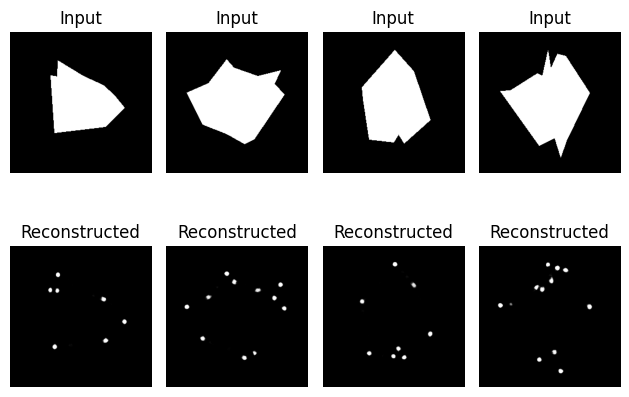

In [12]:
model.eval()
with torch.no_grad():
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        break  # only one batch

# Show first 4 reconstructions
for i in range(4):
    inp = inputs[i].cpu().squeeze().numpy()
    out = outputs[i].cpu().squeeze().numpy()
    
    plt.subplot(2, 4, i+1)
    plt.imshow(inp, cmap="gray")
    plt.title("Input")
    plt.axis("off")
    
    plt.subplot(2, 4, i+5)
    plt.imshow(out, cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [183]:
def extract_coordinates_from_heatmap(heatmap_tensor, threshold=0.5, center=None, degrees=True):
    heatmap = heatmap_tensor.squeeze().cpu().numpy()  # (H, W)
    H, W = heatmap.shape
    binary = (heatmap > threshold).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if center is None:
        center = (W // 2, H // 2)

    cx, cy = center
    polar_coords = []

    for i in range(1, num_labels):  # skip background
        x, y = centroids[i]
        dx, dy = x - cx, y - cy
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        if degrees:
            angle = np.degrees(angle) % 360
        polar_coords.append((radius, angle))

    # Sort by radius (distance from center)
    polar_coords.sort(key=lambda x: x[0])

    return polar_coords

In [1]:
def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.5)
        print("Detected corners:", corner_coords)

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0000\img2.png")
plt.imshow(result_img, cmap="gray")
plt.show()

NameError: name 'cv2' is not defined